In [1]:
# necessary imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.patches as patches
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import files
from google.colab import drive

In [2]:
# mount g drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_path = '/content/drive/MyDrive/capstone_dataset/'

# Setup Kaggle API and get Dataset

In [ ]:
# check if kaggle.json already exists
kaggle_path = os.path.expanduser('~/.kaggle/kaggle.json')

if not os.path.exists(kaggle_path):
    # upload kaggle.json for kaggle API
    _ = files.upload()

    # setup kaggle.json for API
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# get dataset from Kaggle
!kaggle datasets download -d nih-chest-xrays/data

Fatal Python error: init_import_site: Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/usr/lib/python3.10/site.py", line 636, in <module>
    main()
  File "/usr/lib/python3.10/site.py", line 623, in main
    known_paths = addsitepackages(known_paths)
  File "/usr/lib/python3.10/site.py", line 406, in addsitepackages
    addsitedir(sitedir, known_paths)
  File "/usr/lib/python3.10/site.py", line 232, in addsitedir
    addpackage(sitedir, name, known_paths)
  File "/usr/lib/python3.10/site.py", line 192, in addpackage
    exec(line)
  File "<string>", line 1, in <module>
KeyboardInterrupt


In [ ]:
zip_path = '/content/data.zip'
unzip_path = '/content/capstone_dataset/'

!mkdir -p {unzip_path}
# extract dataset into google drive, output silenced
!unzip {zip_path} -d {unzip_path} > /dev/null

In [ ]:
!mkdir -p {drive_path}
# move full dataset to g drive (30+ minutes!)
!mv {unzip_path}* {drive_path}

mv: inter-device move failed: '/content/capstone_dataset/images_001' to '/content/drive/MyDrive/capstone_dataset/images_001'; unable to remove target: Directory not empty


# Indexing Image Directories

In [5]:
df = pd.read_csv(drive_path + 'Data_Entry_2017.csv')

In [6]:
image_paths = {}

for subdir, _, files in os.walk(drive_path):
    for file in files:
        if file.endswith('.png'):
            # Ensure the dictionary key is just the filename
            image_paths[file] = os.path.join(subdir, file)

print(f"Found {len(image_paths)} images.")

Found 112120 images.


In [7]:
df['Image Path'] = df['Image Index'].apply(lambda x: image_paths.get(x))

In [8]:
df.to_csv(drive_path + 'Data_with_image_paths.csv')

# EDA

In [9]:
df = pd.read_csv(drive_path + 'Data_with_image_paths.csv')
df.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Image Path
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/drive/MyDrive/capstone_dataset/images...
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/drive/MyDrive/capstone_dataset/images...
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/drive/MyDrive/capstone_dataset/images...
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/drive/MyDrive/capstone_dataset/images...
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/drive/MyDrive/capstone_dataset/images...


## Dataset Overview and Descriptive statistics

In [10]:
print("Number of Rows:", len(df))
print("Number of Unique Images:", df["Image Index"].nunique())
print("Number of Unique Patients:", df["Patient ID"].nunique())

# Utilizing `df.describe()` to generate descriptive statistics for numerical columns.
df.describe()

Number of Rows: 112120
Number of Unique Images: 112120
Number of Unique Patients: 30805


,Unnamed: 0,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,56059.500000,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,32366.400428,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,28029.750000,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,56059.500000,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,84089.250000,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,112119.000000,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


## Filtering and missing data

In [11]:
# Addressing potential age entry errors by removing records with ages above 120 years.
df = df[df['Patient Age'] <= 120]
df.reset_index(drop=True, inplace=True)

In [12]:
# check for NA values
df.isna().sum()

Unnamed: 0                          0
Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112104
Image Path                          0
dtype: int64

In [13]:
df.drop(columns='Unnamed: 11', inplace=True)

## Variable Exploration

### Image index
The 'Image Index' holds valuable information encoded in the file names (e.g., 00000001_000.png). The number preceding the underscore corresponds to the 'Patient ID', while the number after represents the image number for that patient.

In [14]:
print(df["Image Index"][0:5])

0    00000001_000.png
1    00000001_001.png
2    00000001_002.png
3    00000002_000.png
4    00000003_000.png
Name: Image Index, dtype: object


### Target

Key Characteristics:

Multi-label Classification: Images can have "No Finding" or one or more of 14 disease classes (Atelectasis, Consolidation, Infiltration, etc.).

Label Combinations: There are numerous unique combinations of labels, requiring careful handling during model training.

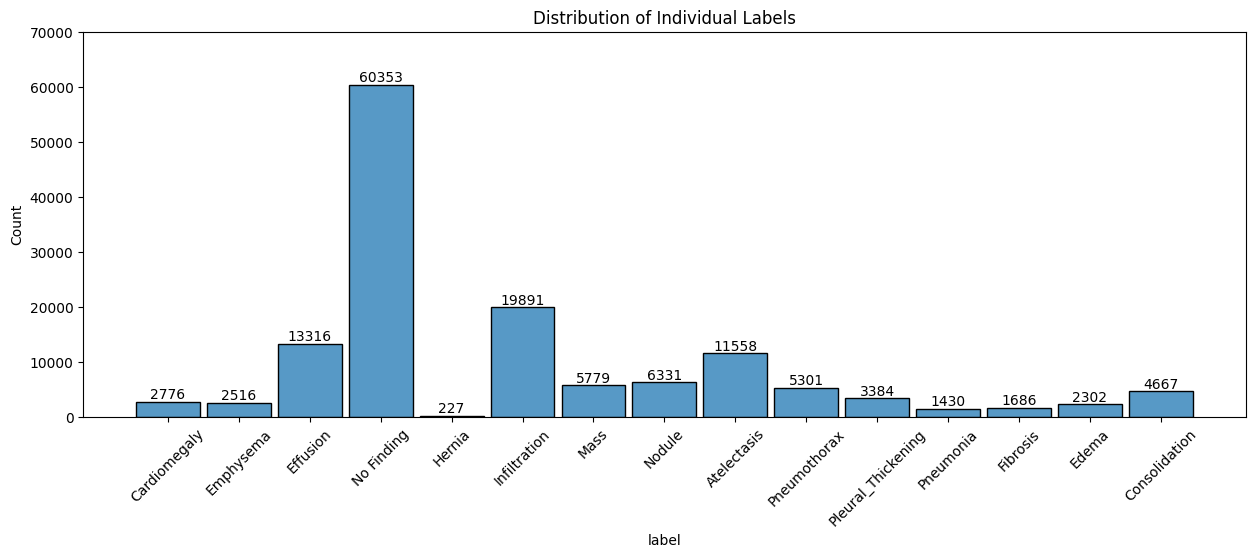

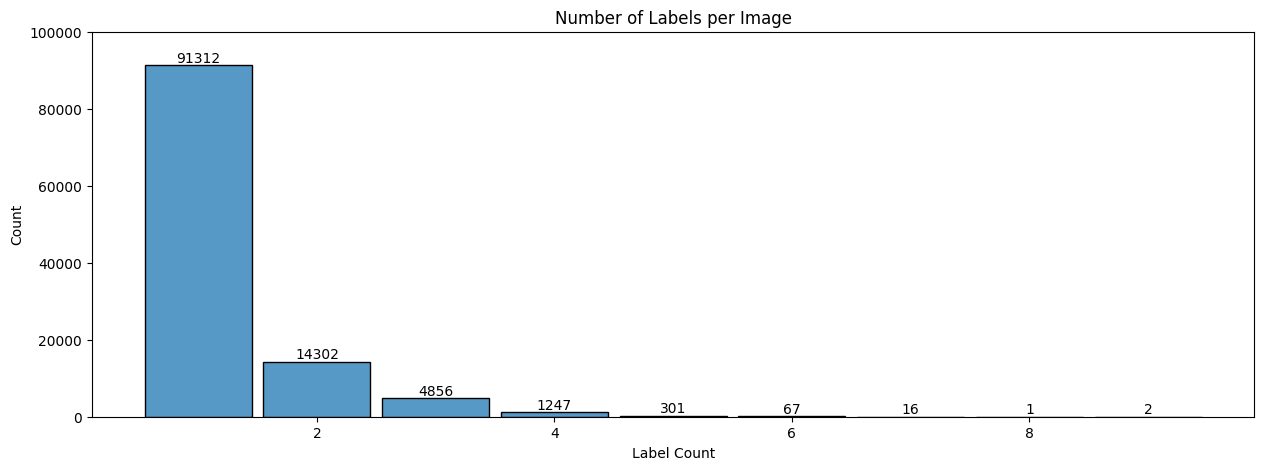

In [15]:
# Splitting labels and counting occurrences
label_counts = df.assign(
    var1=df['Finding Labels'].str.split('|')).explode('var1')["var1"]
label_counts = label_counts.reset_index(drop=True).to_frame()
label_counts.columns = ["label"]

fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=45)
sns.histplot(
    label_counts, x="label", discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of Individual Labels")
ax.bar_label(ax.containers[0])
plt.ylim(0, 70000)
plt.show()

# Analyzing the number of labels per image
labels_per_image = df["Finding Labels"].str.count(r'\|') + 1
labels_per_image = labels_per_image.reset_index(drop=True).to_frame()
labels_per_image.columns = ["Label Count"]

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    labels_per_image,
    x="Label Count",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Number of Labels per Image")
ax.bar_label(ax.containers[0])
plt.ylim(0, 100000)
plt.show()

### Other Features

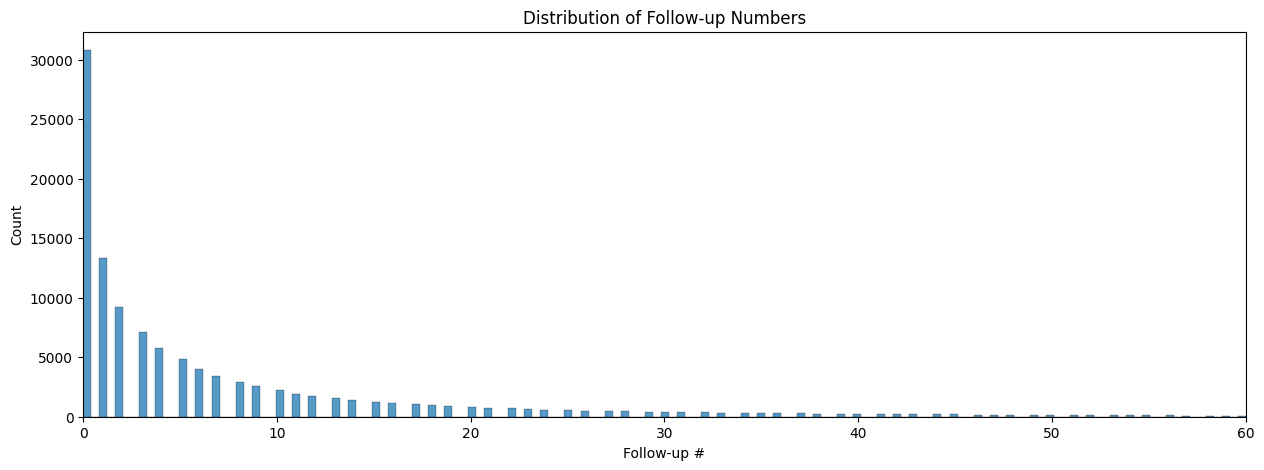

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df, x="Follow-up #", ax=ax).set_title(
    'Distribution of Follow-up Numbers')
plt.xlim(0, 60)
plt.show()

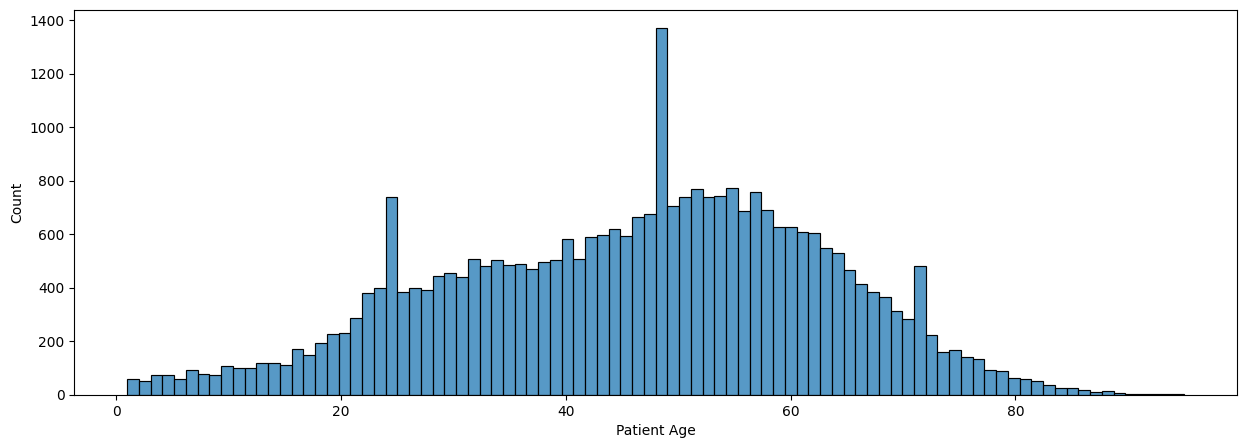

In [17]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(test, x="Patient Age", ax=ax, bins=90)
plt.show()

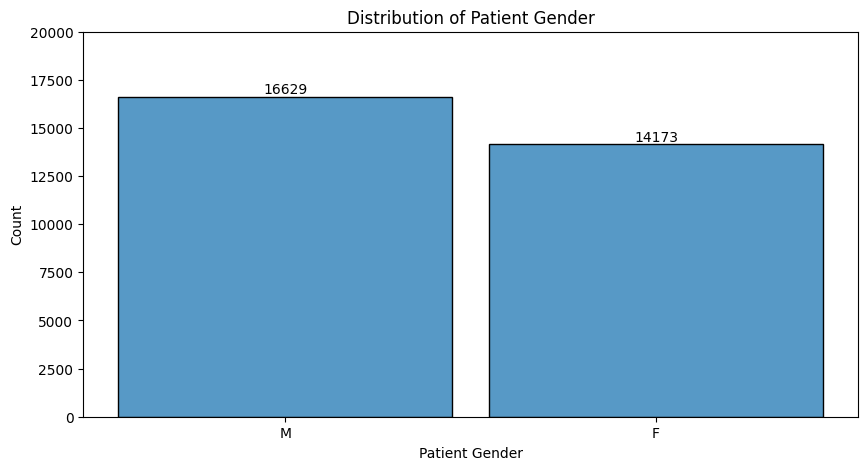

In [18]:
test = df.groupby("Patient ID").agg('first')

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    test,
    x="Patient Gender",
    discrete=True,
    ax=ax,
    shrink=.9).set_title("Distribution of Patient Gender")
ax.bar_label(ax.containers[0])
plt.ylim(0, 20000)
plt.show()

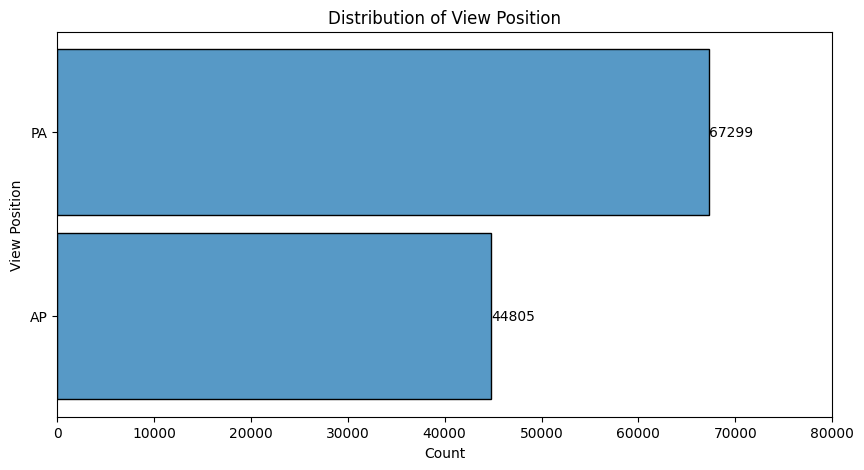

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    df, y='View Position', discrete=True, ax=ax, shrink=.9).set_title(
        "Distribution of View Position")
ax.bar_label(ax.containers[0])
plt.xlim(0, 80000)
plt.show()

## Feature relationships

In [20]:
cols_of_interest = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position", 'Image Path'
]

df = df[cols_of_interest]

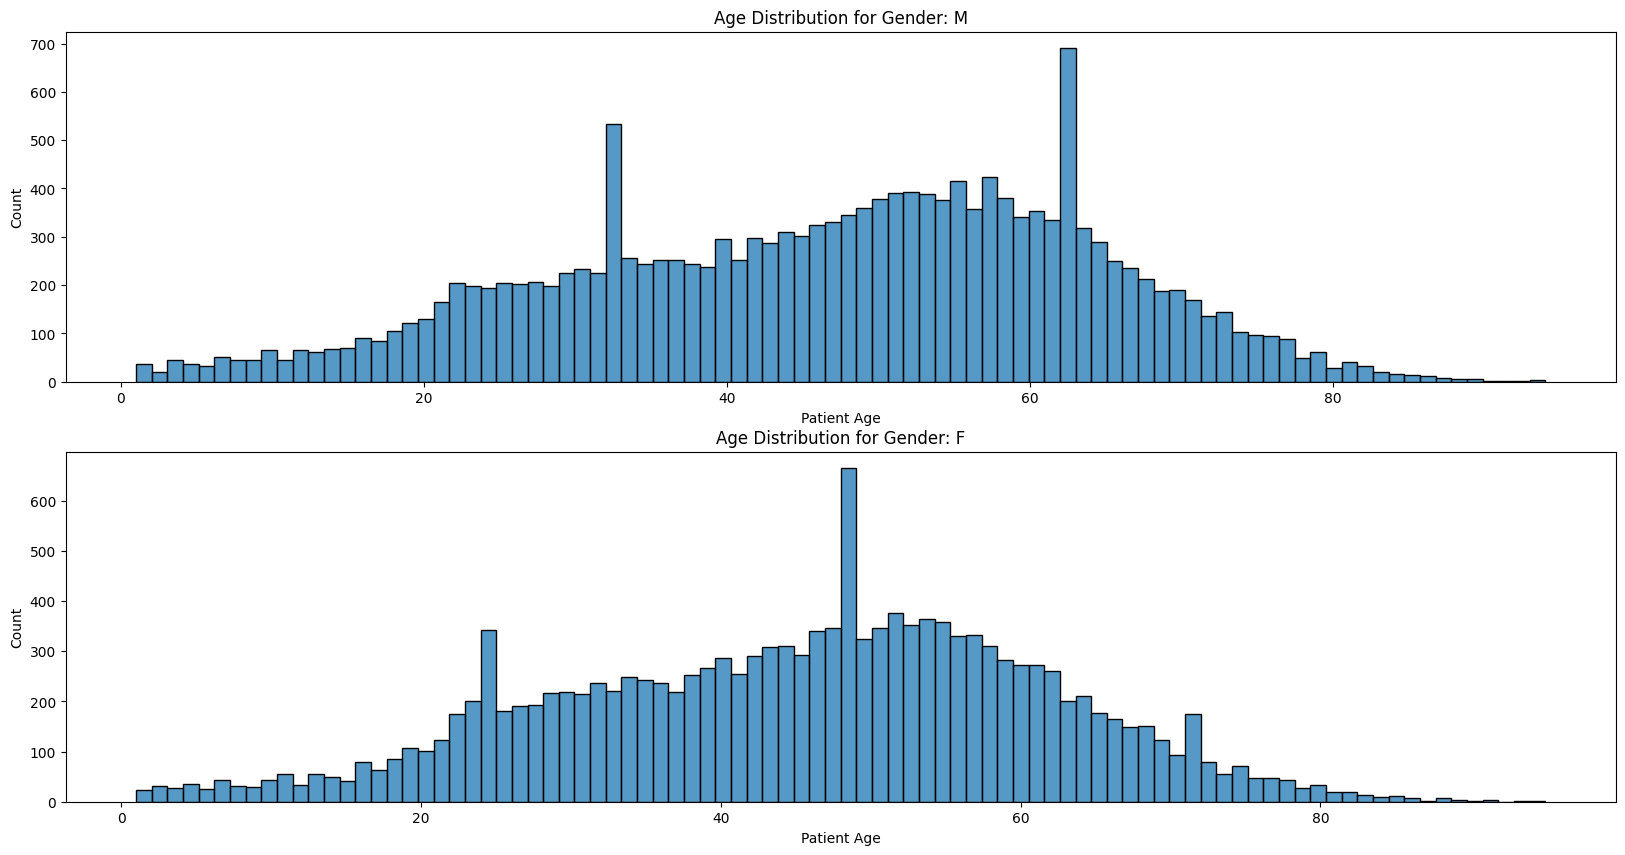

In [21]:
test = df.groupby("Patient ID").agg('first')
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

for i, val in enumerate(["M", "F"]):
    test1 = test[test['Patient Gender'] == val].reset_index()
    sns.histplot(test1, x="Patient Age", ax=axes[i], bins=90)
    axes[i].set_title(f"Age Distribution for Gender: {val}")

plt.show()

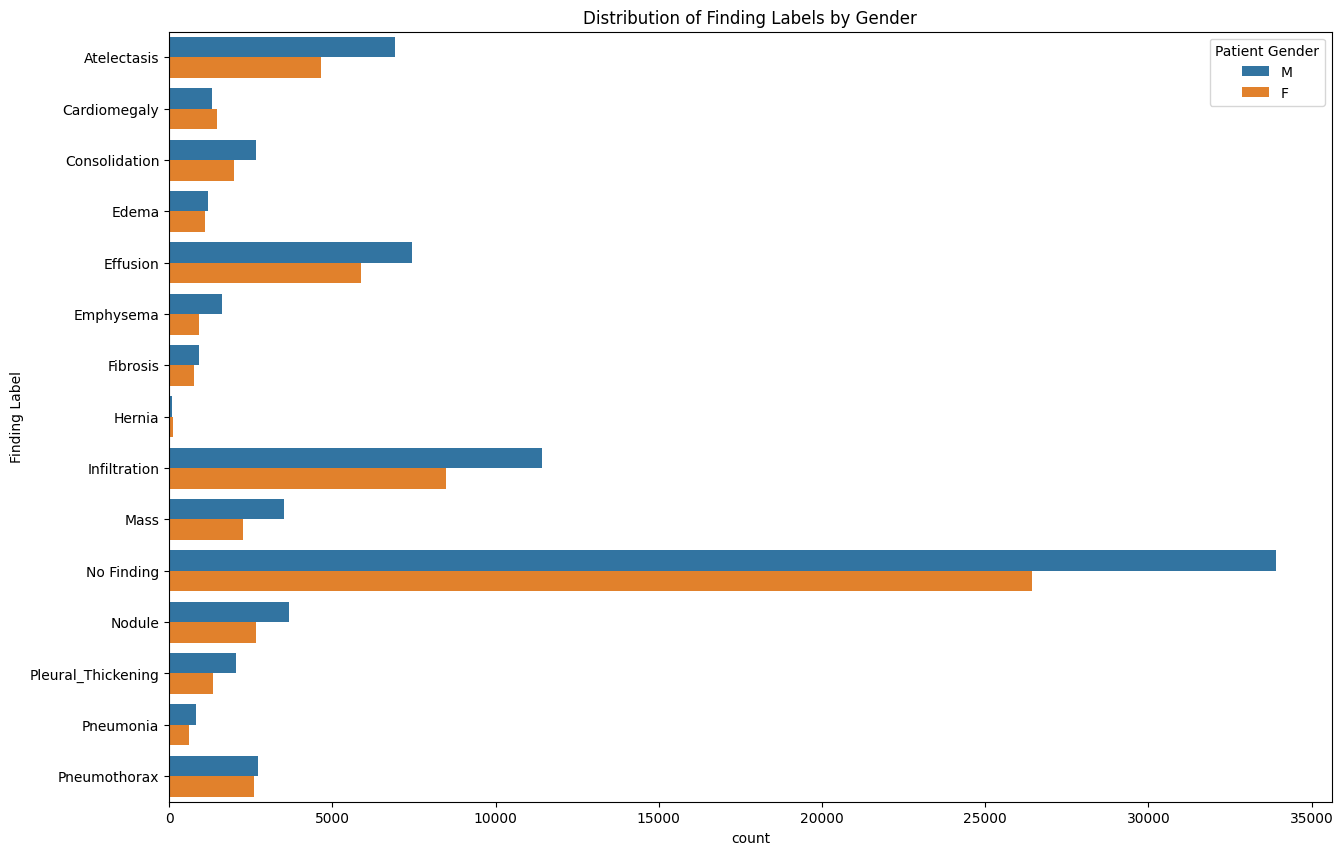

In [22]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
plot_df = pd.DataFrame()

for val in ["M", "F"]:
    test1 = test[test["Patient Gender"] == val].reset_index(drop=True)
    test1 = test1.groupby("var1").size().sort_index().reset_index(
        name="count")
    test1["Patient Gender"] = val

    plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

plt.figure(figsize=(15, 10))
plt.title("Distribution of Finding Labels by Gender")
ax = sns.barplot(
    y="var1", hue="Patient Gender", x="count", data=plot_df, orient='h')
plt.ylabel("Finding Label")
plt.show()

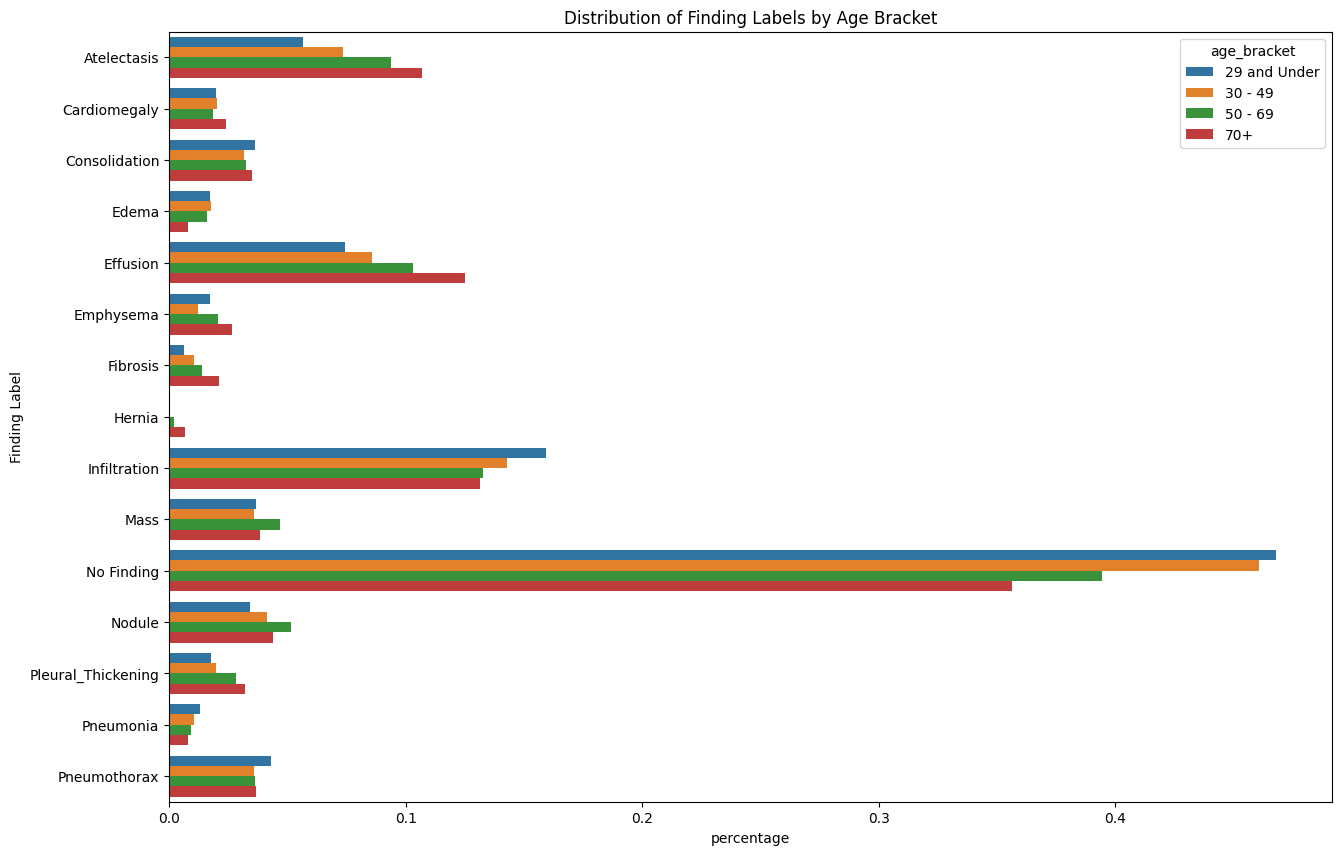

In [23]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Patient Age'] <= 29),
    (test['Patient Age'] >= 30) & (test['Patient Age'] <= 49),
    (test['Patient Age'] >= 50) & (test['Patient Age'] <= 69),
    (test['Patient Age'] >= 70)
]

choices = ['29 and Under', '30 - 49', '50 - 69', '70+']
test['age_bracket'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("age_bracket").sum("count").reset_index()

test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(15, 10))
plt.title("Distribution of Finding Labels by Age Bracket")
ax = sns.barplot(
    y="var1",
    hue="age_bracket",
    x="percentage",
    data=test1,
    orient='h')
plt.ylabel("Finding Label")
plt.show()

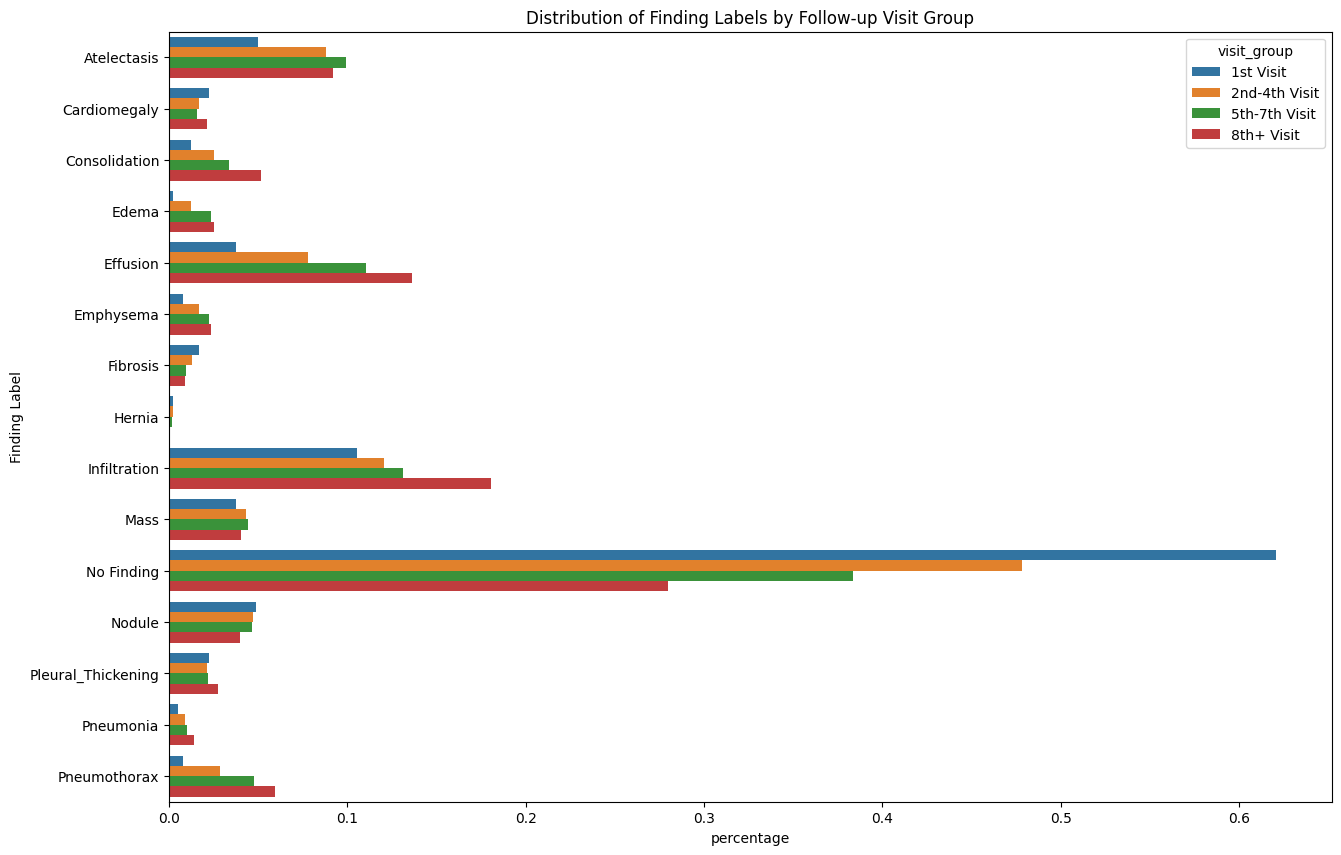

In [24]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')

conditions = [
    (test['Follow-up #'] == 0),  # First visit
    (test['Follow-up #'] >= 1) & (test['Follow-up #'] <= 3),
    (test['Follow-up #'] >= 4) & (test['Follow-up #'] <= 6),
    (test['Follow-up #'] >= 7)
]

choices = ['1st Visit', '2nd-4th Visit', '5th-7th Visit', '8th+ Visit']
test['visit_group'] = np.select(conditions, choices, default=np.nan)
test1 = test.groupby(
    ["visit_group", "var1"]).size().sort_index().reset_index(name="count")
test2 = test1.groupby("visit_group").sum("count").reset_index()

test1 = test1.merge(test2, on='visit_group', suffixes=('', '_total'))
test1["percentage"] = test1["count"] / test1["count_total"]

plt.figure(figsize=(15, 10))
plt.title("Distribution of Finding Labels by Follow-up Visit Group")
ax = sns.barplot(
    y="var1", hue="visit_group", x="percentage", data=test1, orient='h')
plt.ylabel("Finding Label")
plt.show()

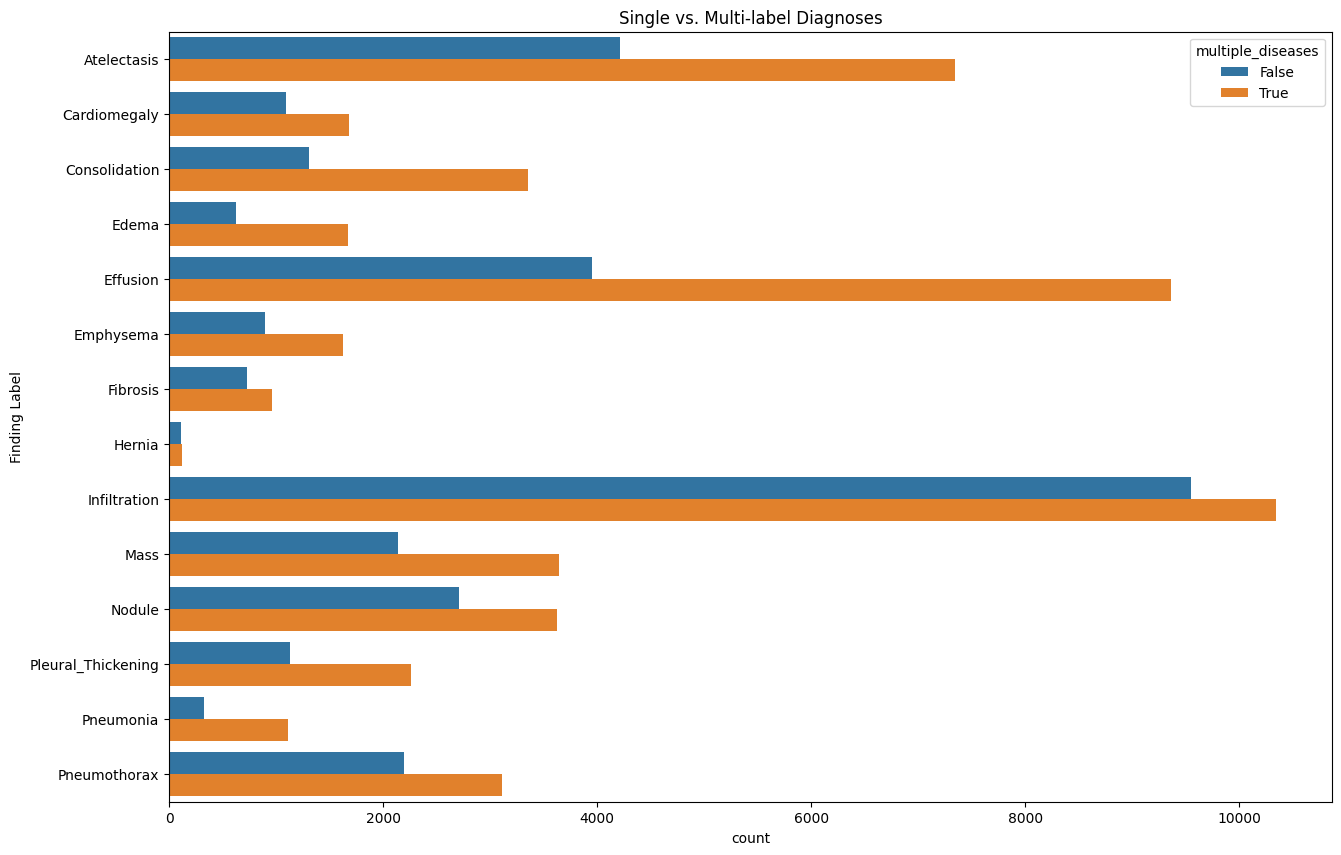

In [25]:
test = df.assign(var1=df['Finding Labels'].str.split('|')).explode('var1')
test["multiple_diseases"] = test[
    'Finding Labels'].str.match(r'\w+\|\w+')  # Identifying multi-label cases
test = test[test["Finding Labels"] != "No Finding"]
test1 = test.groupby(
    ["var1",
        "multiple_diseases"]).size().sort_index().reset_index(name="count")

plt.figure(figsize=(15, 10))
plt.title("Single vs. Multi-label Diagnoses")
ax = sns.barplot(
    y="var1", hue="multiple_diseases", x="count", data=test1, orient='h')
plt.ylabel("Finding Label")
plt.show()

<ipython-input-26-1e07e4688b1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
<ipython-input-26-1e07e4688b1d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))


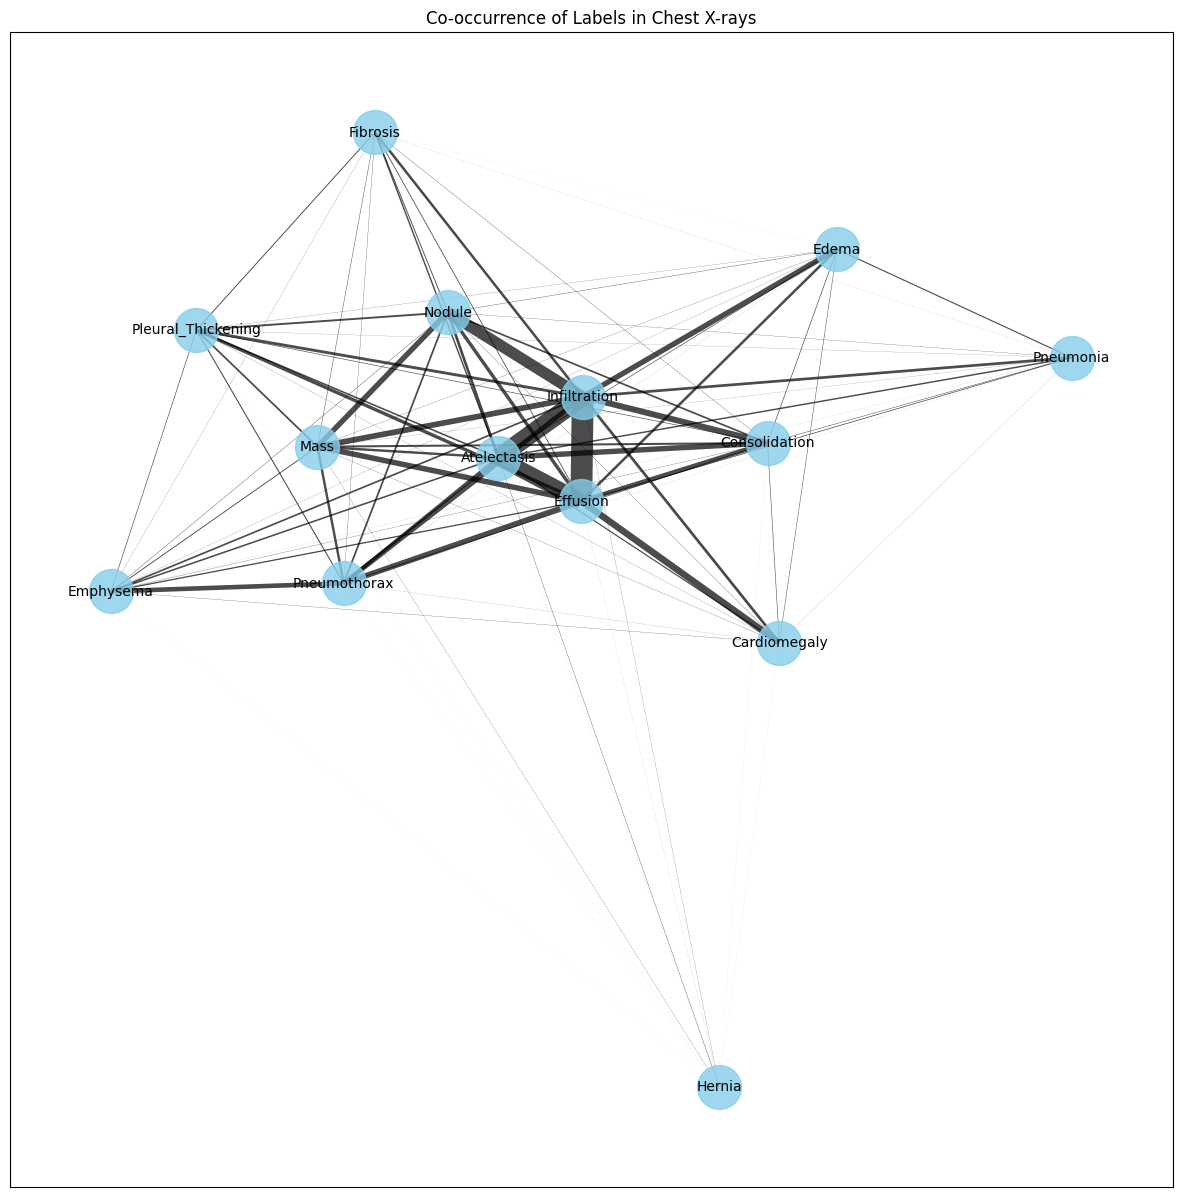

In [26]:
# Preprocessing: Filtering for images with exactly two labels
df_filtered = df[df["Finding Labels"].str.count(r'\|') == 1]
df_filtered["tags"] = df_filtered["Finding Labels"].str.split("|")
df_filtered["tags"] = df_filtered["tags"].apply(lambda x: sorted(x))

# Getting unique labels
all_tags = np.unique(np.concatenate(df_filtered['tags'].values))

# Helper function to add edge weight
def add_edge_weight(head, tail, graph):
    try:
        graph[head][tail]['weight'] += 1
    except:
        graph.add_edge(head, tail, weight=1)

# Initializing the graph
G = nx.Graph()

# Adding nodes (tags)
for t in all_tags:
    G.add_node(t)

# Adding edges (co-occurring tags)
for _, row in df_filtered.iterrows():
    tags = row['tags']
    add_edge_weight(tags[0], tags[1], G)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1.5)  # Adjust k for spacing

# Calculating total edge weights
w_sum = sum([data['weight'] for (_, _, data) in G.edges(data=True)])

# Drawing edges with varying width based on weight
for (node1, node2, data) in G.edges(data=True):
    width = data["weight"] * len(G.nodes) * 10.0 / w_sum
    nx.draw_networkx_edges(
        G, pos, edgelist=[(node1, node2)], width=width, alpha=0.7)

nx.draw_networkx_nodes(
    G, pos, node_size=1000, node_color='skyblue', alpha=0.8)

# Drawing labels without overlap
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
plt.title("Co-occurrence of Labels in Chest X-rays")
plt.show()

## Visualizing images with bounding boxes

        Image Index Finding Label     Bbox [x           y          w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217  86.779661   

          h]  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0  79.186441         NaN         NaN         NaN  


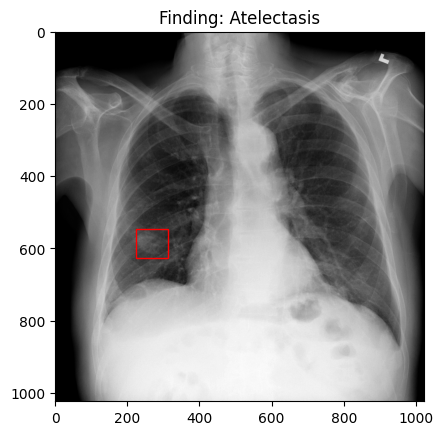

In [27]:
bbox_df = pd.read_csv(drive_path + "BBox_List_2017.csv")

print(bbox_df.head(1))
# Load the first image from dataframe
image_path = drive_path + "images_006/images/" + bbox_df['Image Index'][0]
image = Image.open(image_path)
x = bbox_df['Bbox [x'][0]
y = bbox_df['y'][0]
w = bbox_df['w'][0]
h = bbox_df['h]'][0]

fig, ax = plt.subplots(1)
ax.imshow(image, cmap='gray')

# Create rectangle
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the img
ax.add_patch(rect)

plt.title(f"Finding: {bbox_df['Finding Label'][0]}")
plt.show()

## Target One Hot Encoding

In [28]:
# create list of targets
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

In [29]:
mlb = MultiLabelBinarizer()

ohe_target = mlb.fit_transform(df['Finding Labels'])
ohe_df = pd.DataFrame(ohe_target, columns=mlb.classes_)

target_cols = ohe_df.columns.to_list()

In [30]:
df = pd.concat([df, ohe_df], axis=1)
df.drop(columns='Finding Labels', inplace=True)
# df.columns = df.columns.str.replace(' ', '_')

df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,M,PA,/content/drive/MyDrive/capstone_dataset/images...,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,/content/drive/MyDrive/capstone_dataset/images...,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,/content/drive/MyDrive/capstone_dataset/images...,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,M,PA,/content/drive/MyDrive/capstone_dataset/images...,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,3,81,F,PA,/content/drive/MyDrive/capstone_dataset/images...,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Feature Label Encoding

In [31]:
le_gender = LabelEncoder()
le_view_position = LabelEncoder()

df['Patient Gender'] = le_gender.fit_transform(df['Patient Gender'])
df['View Position'] = le_view_position.fit_transform(df['View Position'])

In [32]:
df.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Image Path,Atelectasis,Cardiomegaly,Consolidation,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,58,1,1,/content/drive/MyDrive/capstone_dataset/images...,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,1,1,/content/drive/MyDrive/capstone_dataset/images...,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,1,1,/content/drive/MyDrive/capstone_dataset/images...,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,81,1,1,/content/drive/MyDrive/capstone_dataset/images...,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,0,3,81,0,1,/content/drive/MyDrive/capstone_dataset/images...,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [33]:
df.to_csv(drive_path + 'final_dataset.csv')

# Modeling prep

## TTS

In [4]:
df = pd.read_csv(drive_path + 'final_dataset.csv')

In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=1997)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1997)

print(f'Training size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Testing size: {len(test_df)}')

Training size: 89683
Validation size: 11210
Testing size: 11211


## Creating Datasets

In [8]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

def image_label_pairs(dataframe):
    image_paths = dataframe['Image Path'].values
    labels = dataframe.iloc[:, -15:].values
    return image_paths, labels

In [9]:
train_image_paths, train_labels = image_label_pairs(train_df)
val_image_paths, val_labels = image_label_pairs(val_df)
test_image_paths, test_labels = image_label_pairs(test_df)

In [10]:
def create_dataset(image_paths, labels, batch_size, shuffle=True):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = path_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [11]:
batch_size = 32
train_dataset = create_dataset(train_image_paths, train_labels, batch_size)
val_dataset = create_dataset(val_image_paths, val_labels, batch_size, shuffle=False)
test_dataset = create_dataset(test_image_paths, test_labels, batch_size, shuffle=False)

# Initial modeling

In [12]:
# verify GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(15, activation='sigmoid')  # 15 outputs for multi-label classification
])

In [14]:
# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Adjust the number of epochs based on your dataset and requirements
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
